In [1]:
import sys
sys.path.insert(0, '..')

Recently we discovered a missmatch between corrected and original images. In particular it seemed that in some cases, some images that looked initially fine were corrected in a way that original data was lost. Thus, in this notebook I attempt to understand what is going on throughout the pipeline from source data until the formation of the database.

# 1. Recreate the problem
Let us illustrate the problem by recreating it. This is inspired (if not copied) from the notebook "Analyse Corrected".

In [2]:
# Import libraries
from pyphoon.db import pd_manager
from pyphoon.io.h5 import read_source_image
from pyphoon.io.typhoonlist import create_typhoonlist_from_source
from pyphoon.clean.fix import TyphoonListImageFixAlgorithm
from pyphoon.clean.detection import detect_corrupted_pixels_1
from pyphoon.clean.correction import correct_corrupted_pixels_1
from os.path import exists, join
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Change this depending where your working directory is located
orig_images_dir = '../../../../datasets/typhoon/wnp/image/'
corrected_dir = '../../../database/corrected'
db_dir = '../../../database/'

images_dir = join(db_dir, 'images.pkl')
corrupted_dir = join(db_dir, 'corrupted.pkl')

In [4]:
# Load database
pd_man = pd_manager.PDManager()
pd_man.load_images(images_dir)
pd_man.load_corrupted(corrupted_dir)

# Join tables to obtain complete table about corrupted data
corrupted_db = pd_man.images.join(pd_man.corrupted, how='inner')

In [5]:
# Show some examples from the database
corrupted_db.head()

directory                     filename    size  \
seq_no obs_time                                                             
197901 1979-01-03 16:00:00    197901  1979010316-197901-GMS1-1.h5  282481   
       1979-01-06 21:00:00    197901  1979010621-197901-GMS1-1.h5  254187   
       1979-01-07 06:00:00    197901  1979010706-197901-GMS1-1.h5  256038   
197902 1979-03-22 03:00:00    197902  1979032203-197902-GMS1-1.h5  242027   
       1979-03-22 06:00:00    197902  1979032206-197902-GMS1-1.h5  242848   

                                    corrupted  corruption  
seq_no obs_time                                            
197901 1979-01-03 16:00:00  197901_1979010316    0.969746  
       1979-01-06 21:00:00  197901_1979010621    0.879063  
       1979-01-07 06:00:00  197901_1979010706    0.871773  
197902 1979-03-22 03:00:00  197902_1979032203    0.000328  
       1979-03-22 06:00:00  197902_1979032206    0.000103

Let us now explore the details of the sequences that have undergone some type of correction. In particular, we will look at the percentage of pixels in an image that have been modified as a consequence of the correcting algorithm. Below is the corresponding histogram.

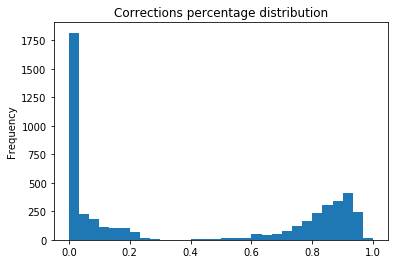

In [6]:
pd_man.corrupted.corruption.plot.hist(bins=30, title='Corrections percentage distribution')
plt.show()

While images with a minor number of modified pixels (peak near 0) were expected, there seem to be plenty of images that were almost completely modified. In this sense, let us disregard the images near zero and focus on those close to 1.

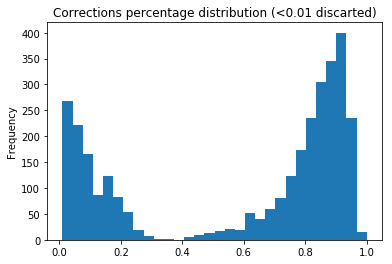

In [7]:
discard_less_than = 0.01
signif_cor = pd_man.corrupted.loc[pd_man.corrupted.corruption >= discard_less_than, :]
signif_cor.corruption.plot.hist(bins=30, title=('Corrections percentage distribution (<{0} discarted)').format(discard_less_than))
plt.show()

Well that was unexpected. Let us see some examples of these images that suffer major modifications. First row show original images, second row modified images.

In [9]:
bins = np.linspace(0, 1, num=30, endpoint=True)
signif_cor['bins']=pd.cut(bins=bins, x=signif_cor.corruption)
binned = signif_cor.groupby(signif_cor.bins)
largest = binned.size().argmax()

n=5
images = binned.get_group(largest).sample(n=n)
files = images.join(pd_man.images).loc[:, ['directory', 'filename']]
orig_images = [read_source_image(join(orig_images_dir, x[1].directory, x[1].filename)) for x in files.iterrows()]
corrected_images = [read_source_image(join(corrected_dir, x[1].directory, x[1].filename)) for x in files.iterrows()]
typhoon_frame_ids = [x[1].filename.split('-')[1]+"_"+x[1].filename.split('-')[0] for x in files.iterrows()]



/fs9/grishin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


NameError: name 'typhoon_ids' is not defined

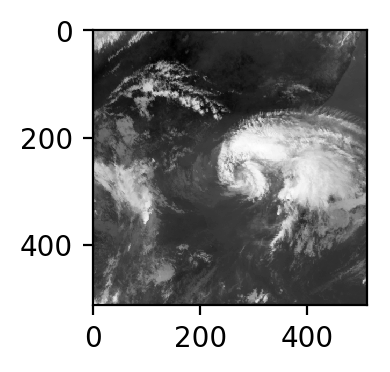

In [10]:
plt.figure(figsize=(20, 4), dpi=200)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_images[i], cmap="Greys")
    plt.title(typhoon_ids[i], fontsize=8)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(corrected_images[i], cmap="Greys")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('correction.png')
plt.show()

# 2. Check source data
We will now use one of the above examples, change the variable `idx` to examine different examples. We will create a `TyphoonList` instance using the source data corresponding to the id specified by `sequence_id` and will apply the correcting algorithm to it.

In [11]:
idx = 0
typhoon_frame_id = typhoon_frame_ids[idx]
typhoon_id = typhoon_frame_id.split('_')[0]

# Create sequence
sequence = create_typhoonlist_from_source(
    name=typhoon_id,
    images="../original_data/image/"+typhoon_id #change path!
)

# Define algorithm
fix_algorithm = TyphoonListImageFixAlgorithm(
    detect_fct=detect_corrupted_pixels_1,
    correct_fct=correct_corrupted_pixels_1,
    detect_params={'min_th': 160, 'max_th': 310},
    n_frames_th=2
)

# Apply fixing algorithm
sequence_corrected = fix_algorithm.apply(sequence)

Let us now visualise the original frame and the corrected one.

KeyError: '198211_1982081403'

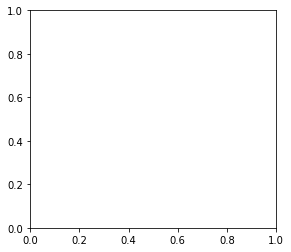

In [12]:
# Plot images
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(sequence.get_data('images', id=typhoon_frame_id), cmap="Greys")
plt.axis('off')
plt.title("Original")
plt.subplot(132)
plt.imshow(sequence_corrected.get_data('images', id=typhoon_frame_id), cmap="Greys")
plt.axis('off')
plt.title("Corrected (source)")
plt.subplot(133)
plt.imshow(corrected_images[idx], cmap="Greys")
plt.title("Corrected (database)")
plt.axis('off')
plt.suptitle(typhoon_frame_id, fontsize=16, y=1.05)
plt.show()

It seems that the retrieved image by the database does not match the actual corrected image. Maybe something wrong in the access methods from `pd_manager`?